Using device: cpu
Analyzing experiment group: 'latent_sweep'
Loading models from: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\checkpoints\checkpoints\latent_sweep
Plots will be saved to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots
Created analysis dataset with 50 images.


Analyzing All Runs:   0%|          | 0/8 [00:00<?, ?it/s]

Run: base=32, lat=1:   0%|          | 0/25 [00:00<?, ?it/s]

Run: base=32, lat=2:   0%|          | 0/25 [00:00<?, ?it/s]

Run: base=32, lat=3:   0%|          | 0/25 [00:00<?, ?it/s]

Run: base=32, lat=4:   0%|          | 0/25 [00:00<?, ?it/s]

Run: base=32, lat=5:   0%|          | 0/25 [00:00<?, ?it/s]

Run: base=32, lat=6:   0%|          | 0/25 [00:00<?, ?it/s]

Run: base=32, lat=7:   0%|          | 0/25 [00:00<?, ?it/s]

Run: base=32, lat=8:   0%|          | 0/25 [00:00<?, ?it/s]


--- Analysis Complete ---


run_id  base_channels  latent_channels  \
0  latent1_base32_lossL1_img1024             32                1   
1  latent2_base32_lossL1_img1024             32                2   
2  latent3_base32_lossL1_img1024             32                3   
3  latent4_base32_lossL1_img1024             32                4   
4  latent5_base32_lossL1_img1024             32                5   
5  latent6_base32_lossL1_img1024             32                6   
6  latent7_base32_lossL1_img1024             32                7   
7  latent8_base32_lossL1_img1024             32                8   

   avg_l2_distance  avg_cosine_similarity  
0         0.147193               0.854274  
1         0.094163               0.933190  
2         0.080755               0.941939  
3         0.044934               0.972545  
4         0.042193               0.973351  
5         0.039078               0.976396  
6         0.046761               0.967208  
7         0.030547               0.980822

C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_21392\3689227511.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="avg_l2_distance", data=df_analysis, ax=axes[0], palette="plasma")
C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_21392\3689227511.py:211: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="avg_cosine_similarity", data=df_analysis, ax=axes[1], palette="viridis")



Saved quantitative comparison plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\quantitative_comparison_latent_sweep.png


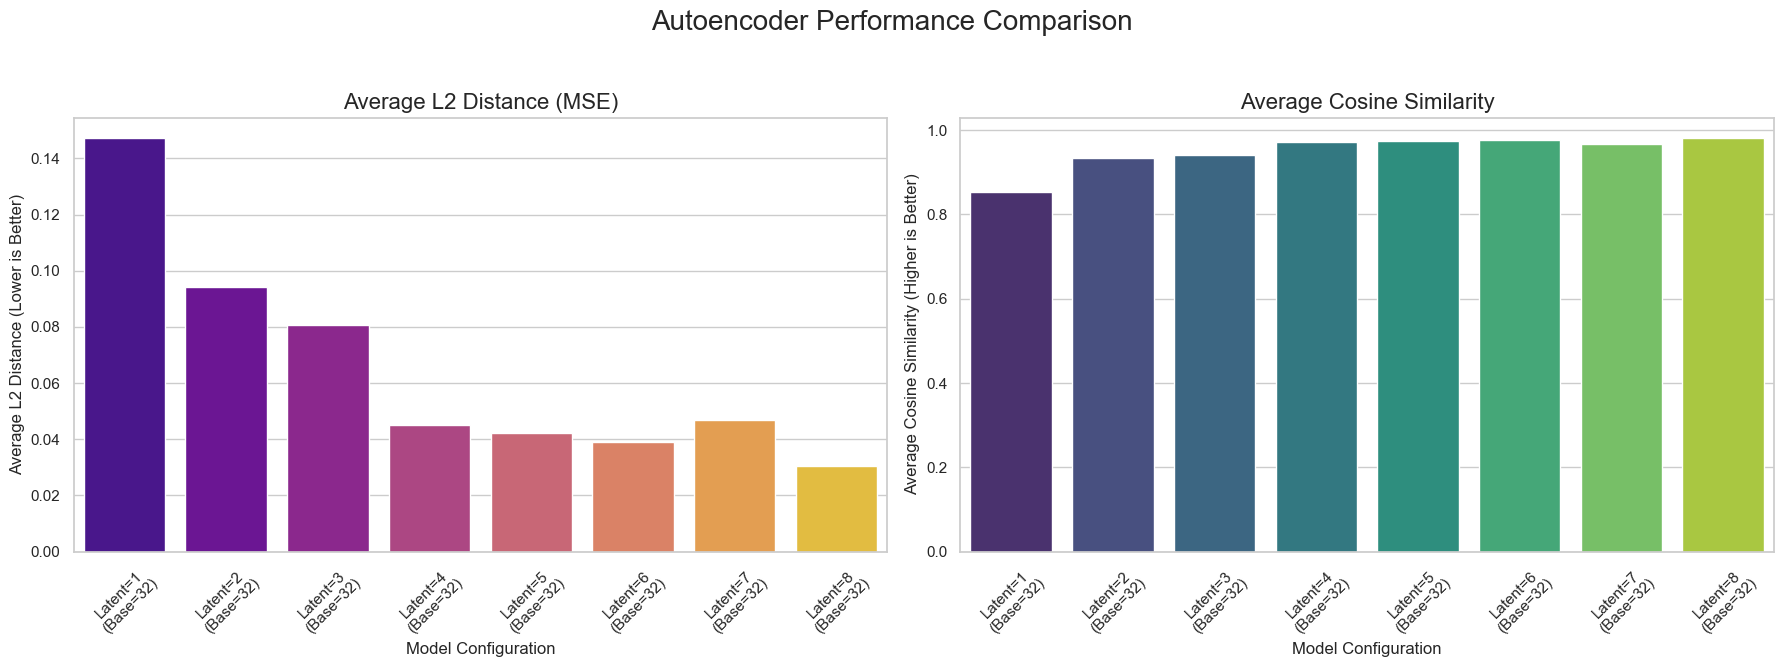

In [ ]:
# =================================================================================
#
#       Deep Analysis of Autoencoder Performance (Refactored + Multi-Plot Saving)
#
# =================================================================================

# --- Core Imports ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import random
import os
import re
import pandas as pd
from pathlib import Path

# --- Analysis and Plotting Imports ---
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from natsort import natsorted

# --- Set a consistent plotting style ---
sns.set_theme(style="whitegrid")

# =================================================================================
#
# SECTION 1: CORRECT MODEL & DATASET DEFINITIONS (Unchanged)
#
# =================================================================================

class Encoder(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, latent_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels * 4, latent_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, out_channels=3, base_channels=64, latent_channels=4):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, base_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z)

class ImageDirectoryDataset(Dataset):
    def __init__(self, image_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# =================================================================================
#
# SECTION 2: REFACTORED CONFIGURATION & DATA LOADING (Unchanged)
#
# =================================================================================

BASE_PROJECT_DIR = Path("C:/Users/Hagai.LAPTOP-QAG9263N/Desktop/Thesis/notebooks")
EXPERIMENT_GROUP = 'latent_sweep'
SOURCE_DATA_DIR = BASE_PROJECT_DIR / "recolored_images"
NUM_SAMPLES_TO_ANALYZE = 50
BATCH_SIZE = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 1024
CHECKPOINT_PATH = BASE_PROJECT_DIR / "checkpoints" / "checkpoints" / EXPERIMENT_GROUP
PLOTS_DIR = BASE_PROJECT_DIR / "plots"

print(f"Using device: {DEVICE}")
print(f"Analyzing experiment group: '{EXPERIMENT_GROUP}'")
if not CHECKPOINT_PATH.exists():
    print(f"!!! FATAL ERROR: Checkpoint directory not found at {CHECKPOINT_PATH}")
    run_dirs = []
else:
    print(f"Loading models from: {CHECKPOINT_PATH}")
    run_dirs = natsorted([d.name for d in CHECKPOINT_PATH.iterdir() if d.is_dir()])

if not SOURCE_DATA_DIR.exists():
    print(f"!!! WARNING: Source data directory for analysis not found at {SOURCE_DATA_DIR}")

PLOTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Plots will be saved to: {PLOTS_DIR}")

analysis_dataloader = None
try:
    all_files = [f.name for f in SOURCE_DATA_DIR.iterdir() if f.is_file() and f.suffix.lower() in ['.png', '.jpg', '.jpeg']]
    if not all_files:
        raise FileNotFoundError(f"No images found in {SOURCE_DATA_DIR}")
    random.seed(42)
    analysis_files = random.sample(all_files, min(len(all_files), NUM_SAMPLES_TO_ANALYZE))
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    analysis_dataset = ImageDirectoryDataset(SOURCE_DATA_DIR, analysis_files, transform)
    analysis_dataloader = DataLoader(analysis_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Created analysis dataset with {len(analysis_dataset)} images.")
except Exception as e:
    print(f"Could not create dataset. Please check the SOURCE_DATA_DIR path. Error: {e}")

# =================================================================================
#
# SECTION 3: REFACTORED DEEP ANALYSIS (NO JSON) (Unchanged)
#
# =================================================================================

analysis_results = []
for run_name in tqdm(run_dirs, desc="Analyzing All Runs"):
    checkpoint_run_path = CHECKPOINT_PATH / run_name
    encoder_path = checkpoint_run_path / "encoder_final.pt"
    decoder_path = checkpoint_run_path / "decoder_final.pt"

    if not encoder_path.exists() or not decoder_path.exists():
        print(f"Skipping '{run_name}': Missing 'encoder_final.pt' or 'decoder_final.pt'.")
        continue

    try:
        match = re.search(r"latent(\d+)_base(\d+)", run_name)
        if not match: raise ValueError("Directory name format is incorrect.")
        lc, bc = int(match.group(1)), int(match.group(2))
    except (ValueError, IndexError):
        print(f"Skipping '{run_name}': Could not parse latent/base channels from name.")
        continue

    try:
        encoder = Encoder(base_channels=bc, latent_channels=lc).to(DEVICE)
        decoder = Decoder(base_channels=bc, latent_channels=lc).to(DEVICE)
        encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))
        decoder.load_state_dict(torch.load(decoder_path, map_location=DEVICE))
        encoder.eval(), decoder.eval()
    except Exception as e:
        print(f"Skipping '{run_name}': ARCHITECTURE MISMATCH or other loading error. Details: {e}")
        continue

    all_l2, all_cosine = [], []
    if analysis_dataloader:
        with torch.no_grad():
            for images in tqdm(analysis_dataloader, desc=f"Run: base={bc}, lat={lc}", leave=False):
                images = images.to(DEVICE)
                recon_images = decoder(encoder(images))
                l2_dist = nn.functional.mse_loss(recon_images, images, reduction='none').mean(dim=[1,2,3])
                cosine_sim = nn.functional.cosine_similarity(recon_images.view(images.size(0), -1), images.view(images.size(0), -1), dim=1)
                all_l2.extend(l2_dist.cpu().numpy())
                all_cosine.extend(cosine_sim.cpu().numpy())

    if all_l2 and all_cosine:
        analysis_results.append({
            "run_id": run_name, "base_channels": bc, "latent_channels": lc,
            "avg_l2_distance": np.mean(all_l2), "avg_cosine_similarity": np.mean(all_cosine)
        })

df_analysis = pd.DataFrame(analysis_results)
if not df_analysis.empty:
    df_analysis = df_analysis.sort_values(by=["base_channels", "latent_channels"]).reset_index(drop=True)

print("\n--- Analysis Complete ---")
if not df_analysis.empty: display(df_analysis)
else: print("No models were successfully analyzed.")

# =================================================================================
#
# SECTION 4 & 5: VISUALIZATION WITH SEPARATE QUALITATIVE PLOTS
#
# =================================================================================

# --- Quantitative Comparison (Unchanged) ---
if not df_analysis.empty:
    df_analysis['label'] = df_analysis.apply(
        lambda row: f"Latent={row['latent_channels']}\n(Base={row['base_channels']})", axis=1
    )
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Autoencoder Performance Comparison', fontsize=20)
    sns.barplot(x="label", y="avg_l2_distance", data=df_analysis, ax=axes[0], palette="plasma")
    axes[0].set_title("Average L2 Distance (MSE)", fontsize=16)
    axes[0].set_xlabel("Model Configuration", fontsize=12)
    axes[0].set_ylabel("Average L2 Distance (Lower is Better)", fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    sns.barplot(x="label", y="avg_cosine_similarity", data=df_analysis, ax=axes[1], palette="viridis")
    axes[1].set_title("Average Cosine Similarity", fontsize=16)
    axes[1].set_xlabel("Model Configuration", fontsize=12)
    axes[1].set_ylabel("Average Cosine Similarity (Higher is Better)", fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = PLOTS_DIR / f"quantitative_comparison_{EXPERIMENT_GROUP}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved quantitative comparison plot to: {save_path}")
    plt.show()
else:
    print("\nAnalysis DataFrame is empty. Cannot generate quantitative plots.")



Generating 8 qualitative plots with 4 samples each...
Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent1_base32_lossL1_img1024.png


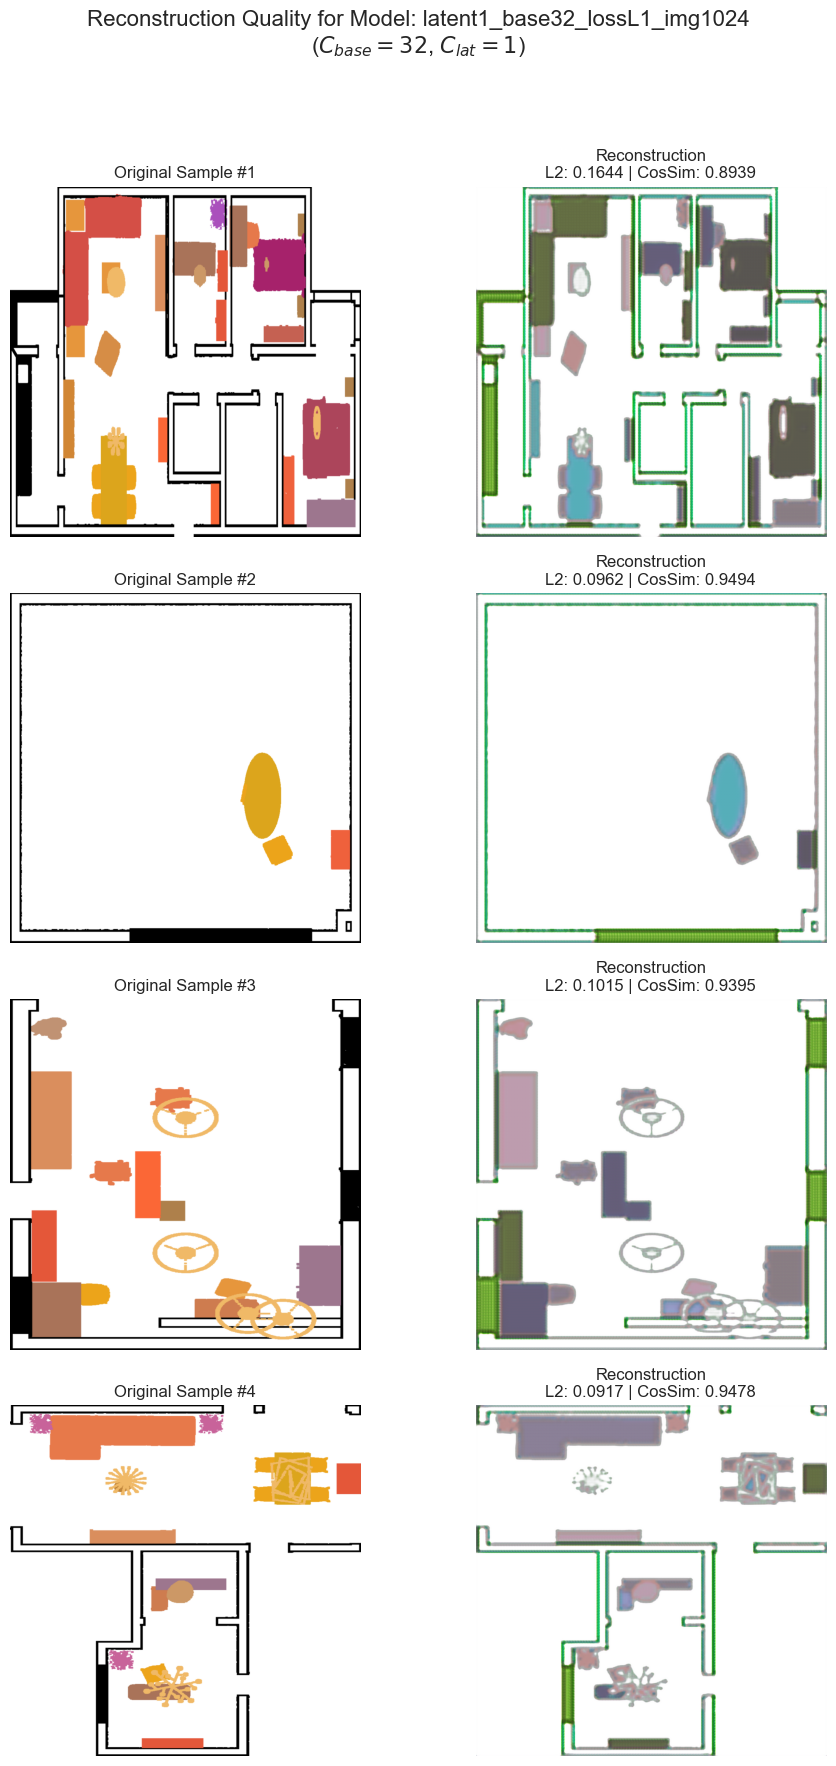

Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent2_base32_lossL1_img1024.png


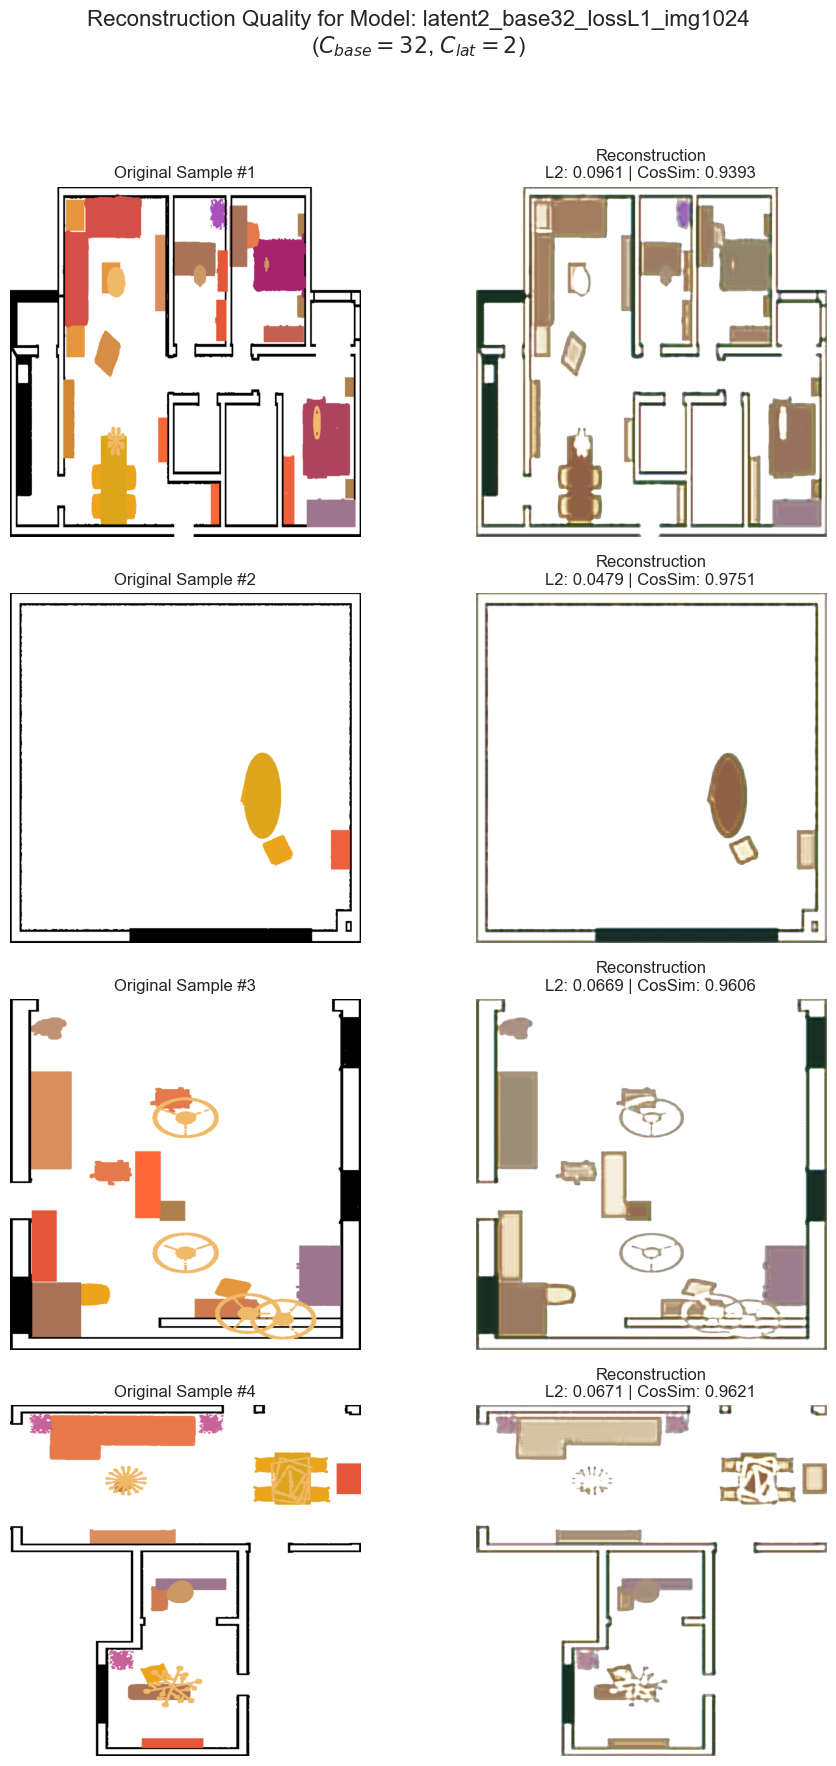

Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent3_base32_lossL1_img1024.png


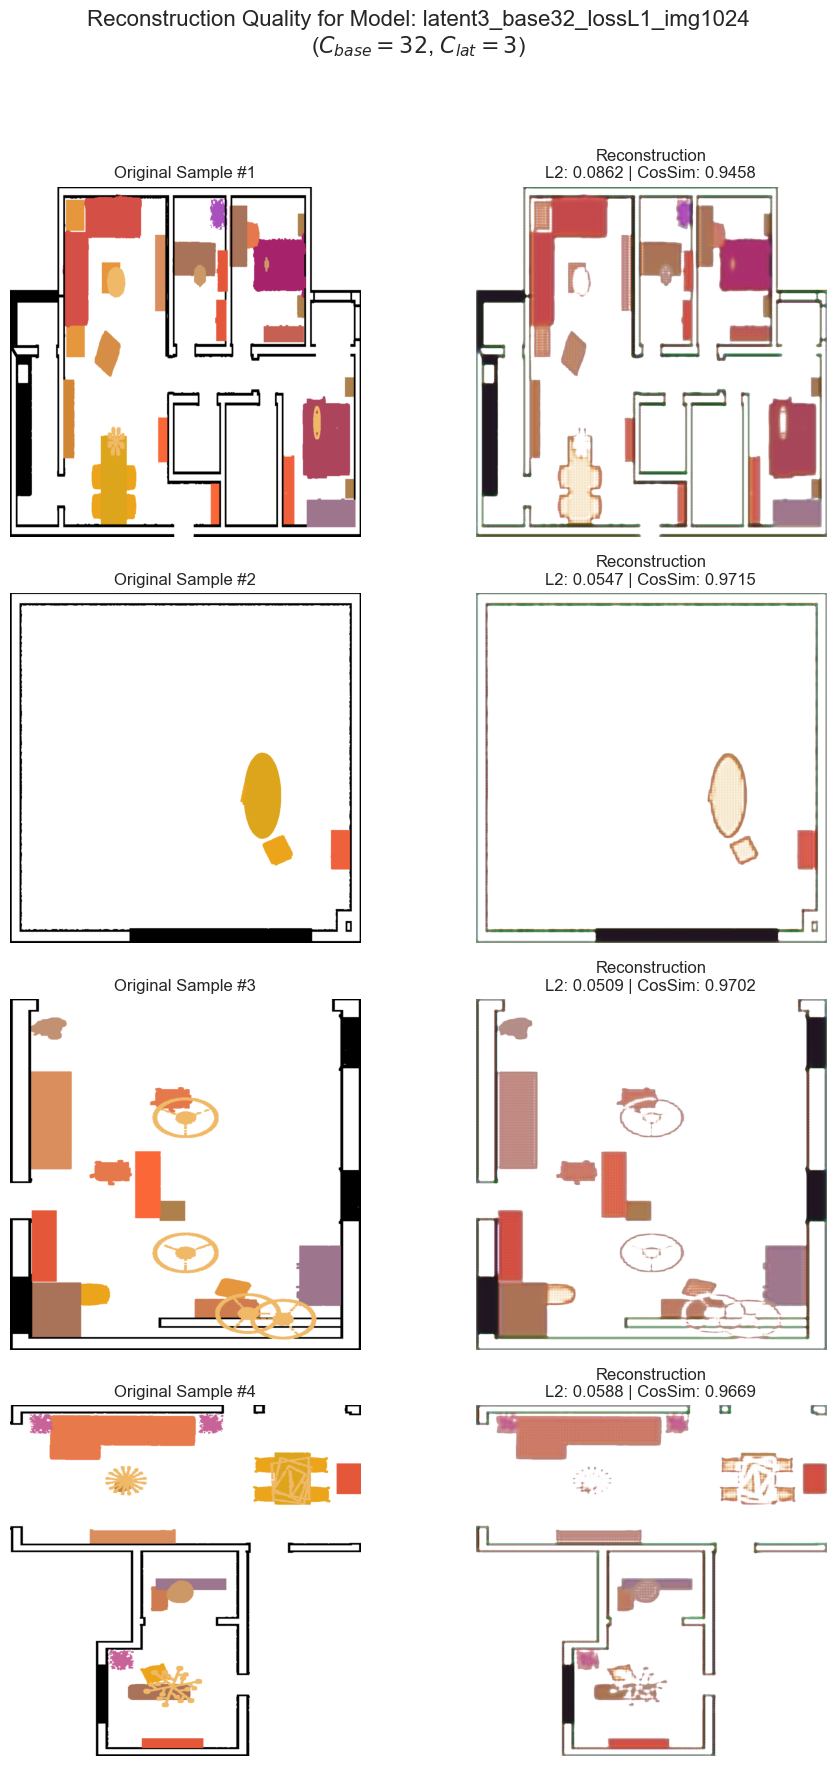

Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent4_base32_lossL1_img1024.png


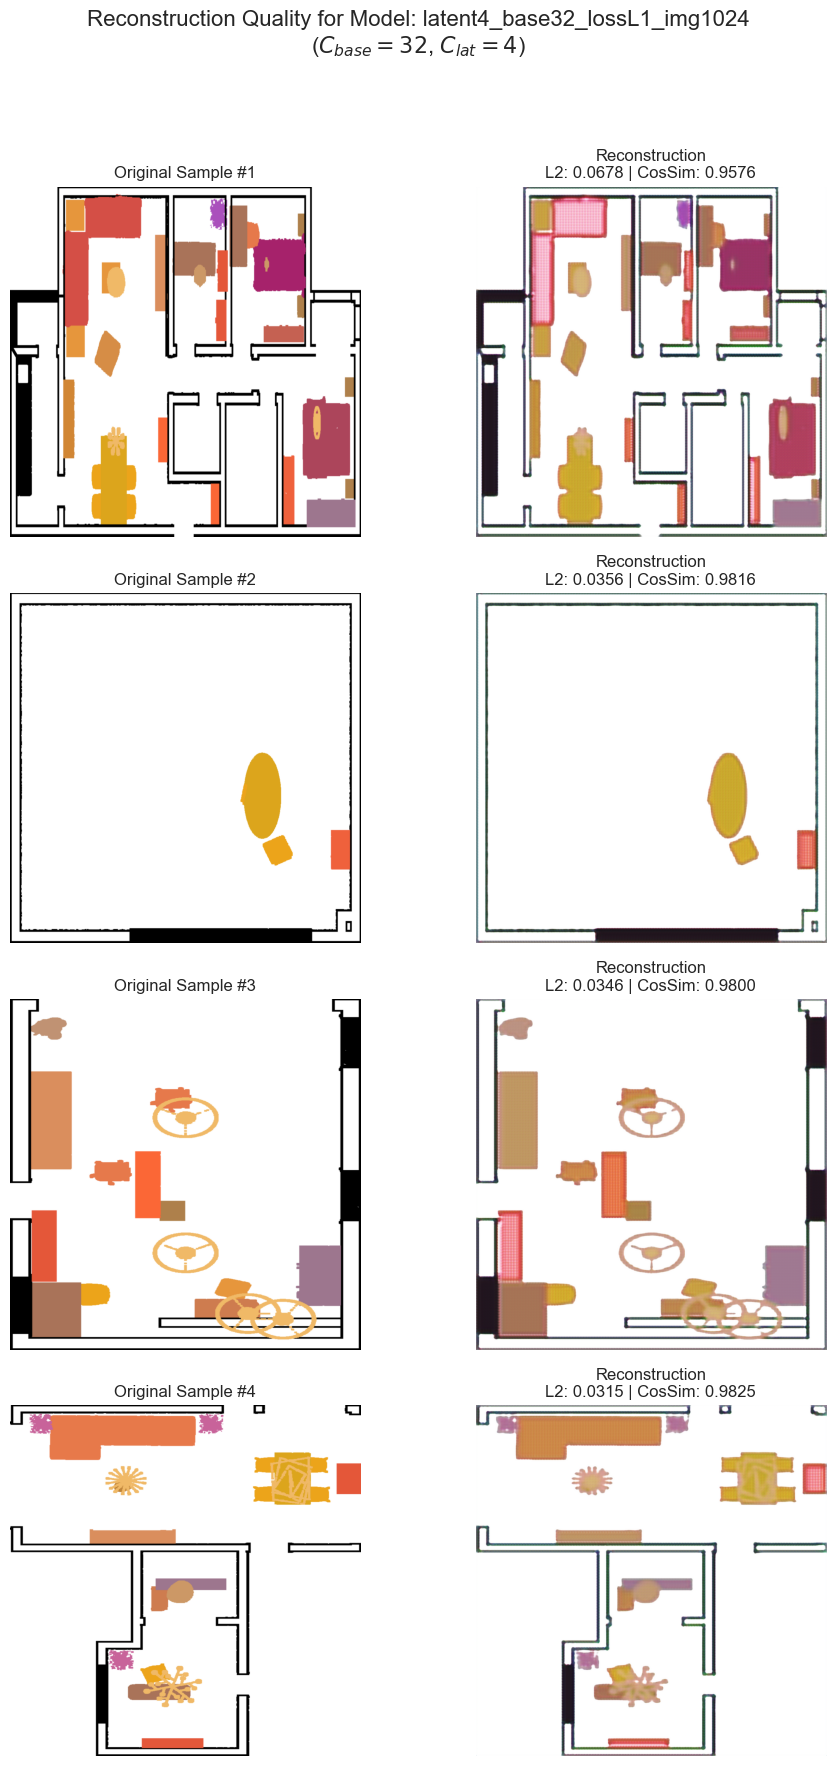

Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent5_base32_lossL1_img1024.png


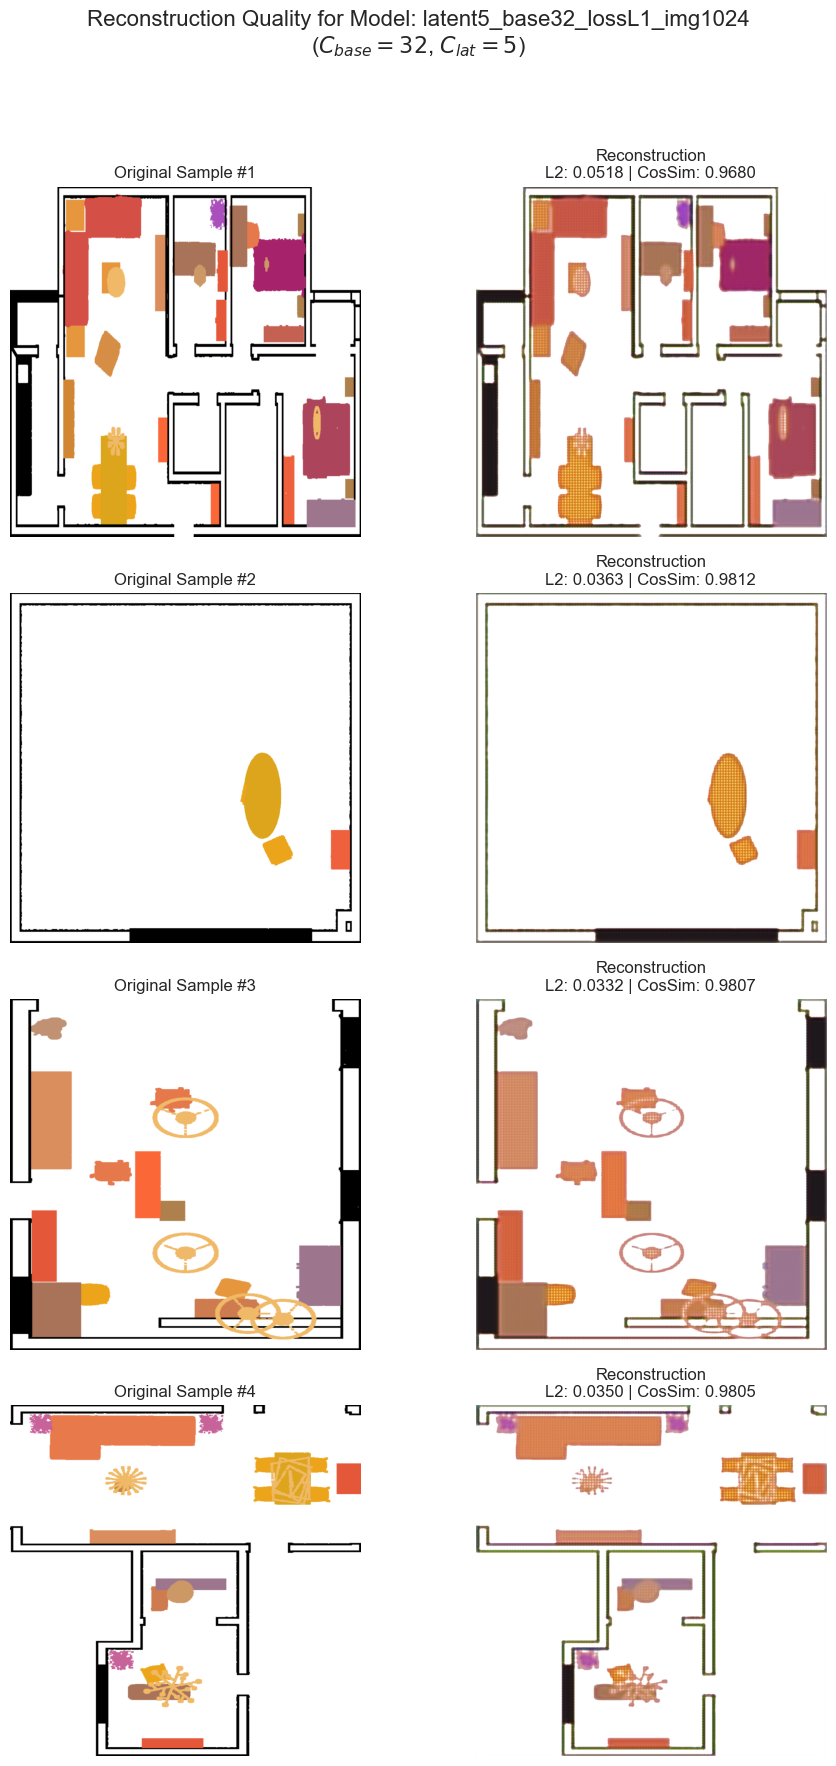

Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent6_base32_lossL1_img1024.png


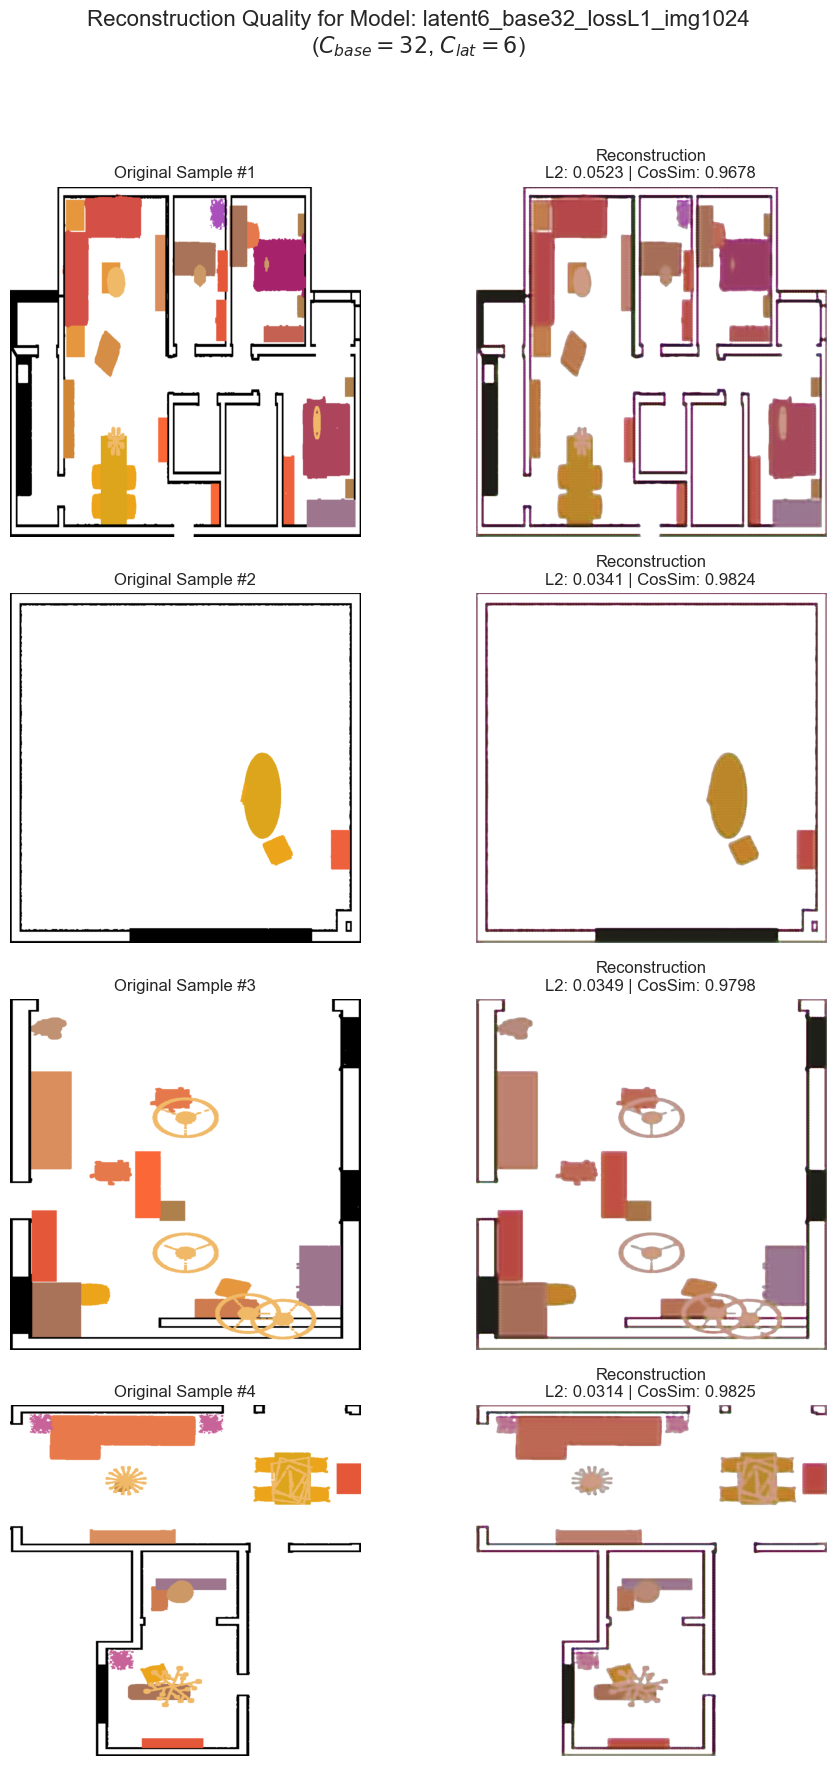

Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent7_base32_lossL1_img1024.png


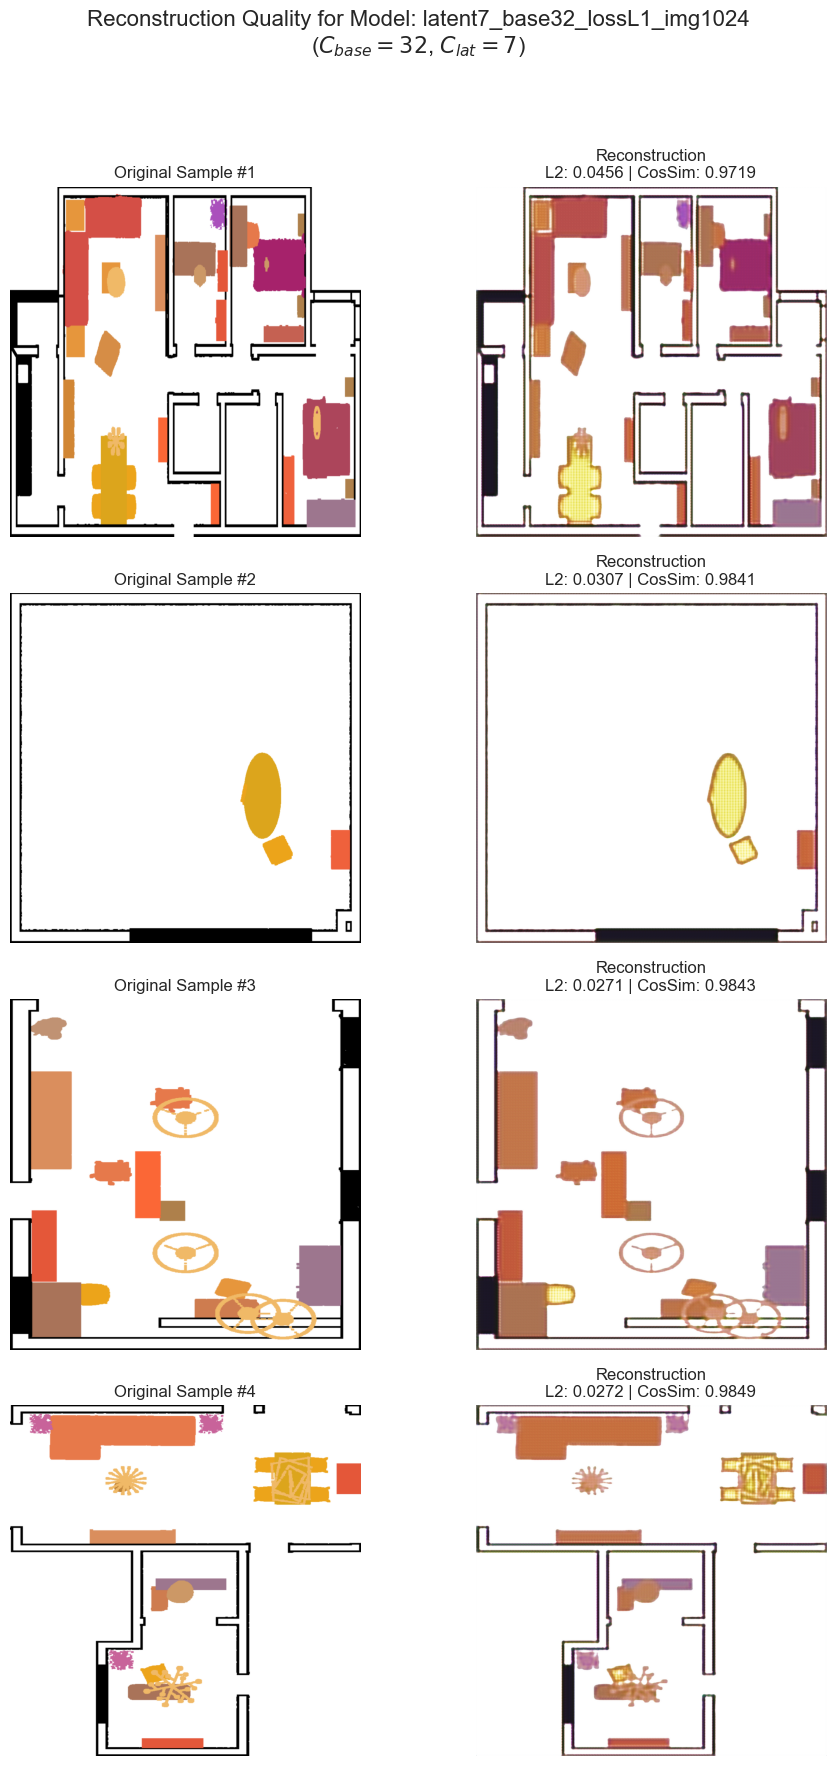

Saved qualitative plot to: C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\notebooks\plots\qualitative_recon_latent8_base32_lossL1_img1024.png


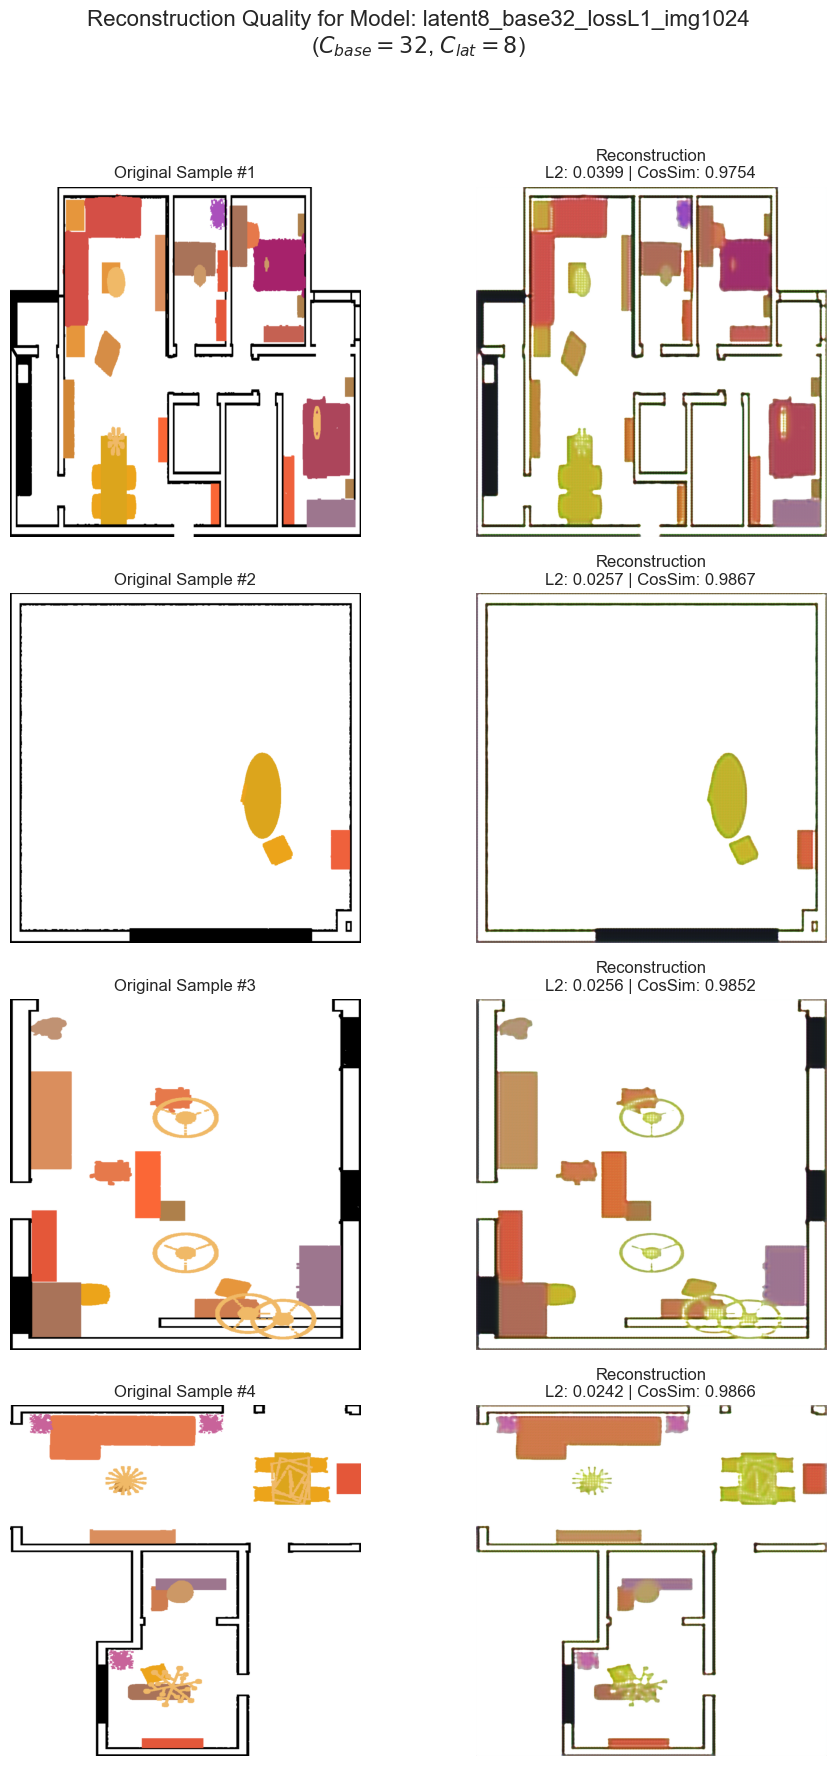

In [4]:

# --- NEW: Qualitative Comparison with Separate Plots per Model ---
if not df_analysis.empty and analysis_dataloader:
    NUM_VISUAL_SAMPLES = 4 # Show 4 samples per model
    print(f"\nGenerating {len(df_analysis)} qualitative plots with {NUM_VISUAL_SAMPLES} samples each...")

    # Select 4 random sample images ONCE to use for all models for fair comparison
    sample_indices = random.sample(range(len(analysis_dataset)), NUM_VISUAL_SAMPLES)
    sample_images = torch.stack([analysis_dataset[i] for i in sample_indices]).to(DEVICE)

    # Loop through each model in the analysis results
    for idx, row in df_analysis.iterrows():
        lc, bc = row['latent_channels'], row['base_channels']
        run_id = row['run_id']
        checkpoint_run_path = CHECKPOINT_PATH / run_id

        # --- Create a new figure for THIS model ---
        # A 4x2 grid: 4 rows, with original on left and recon on right
        fig, axes = plt.subplots(NUM_VISUAL_SAMPLES, 2, figsize=(10, 18))
        fig.suptitle(f'Reconstruction Quality for Model: {run_id}\n($C_{{base}}={bc}$, $C_{{lat}}={lc}$)', fontsize=16)

        # Reload the specific model for this row
        encoder = Encoder(base_channels=bc, latent_channels=lc).to(DEVICE)
        decoder = Decoder(base_channels=bc, latent_channels=lc).to(DEVICE)
        encoder.load_state_dict(torch.load(checkpoint_run_path / "encoder_final.pt", map_location=DEVICE))
        decoder.load_state_dict(torch.load(checkpoint_run_path / "decoder_final.pt", map_location=DEVICE))
        encoder.eval()
        decoder.eval()

        # Get reconstructions for the pre-selected samples
        with torch.no_grad():
            recon_samples = decoder(encoder(sample_images))

        # Helper to un-normalize image for display
        def prep_img(tensor_img):
            return np.clip(tensor_img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, 0, 1)

        # Populate the 4x2 grid for this model
        for i in range(NUM_VISUAL_SAMPLES):
            original, recon = sample_images[i], recon_samples[i]
            l2 = nn.functional.mse_loss(recon, original).item()
            cosine = nn.functional.cosine_similarity(recon.view(1, -1), original.view(1, -1)).item()

            # Plot Original
            axes[i, 0].imshow(prep_img(original))
            axes[i, 0].set_title(f"Original Sample #{i+1}")
            axes[i, 0].axis('off')

            # Plot Reconstruction
            axes[i, 1].imshow(prep_img(recon))
            axes[i, 1].set_title(f"Reconstruction\nL2: {l2:.4f} | CosSim: {cosine:.4f}")
            axes[i, 1].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle

        # --- Save the individual figure ---
        save_path = PLOTS_DIR / f"qualitative_recon_{run_id}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved qualitative plot to: {save_path}")

        plt.show() # Display the figure
        plt.close(fig) # Close the figure to free memory before the next loop iteration

else:
    print("\nAnalysis DataFrame is empty. Cannot generate qualitative comparisons.")